In [1]:
# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

# Handle table-like data and matrices
import numpy as np
import pandas as pd

# Modelling Algorithms
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier , GradientBoostingClassifier

# Modelling Helpers
from sklearn.preprocessing import Imputer , Normalizer , scale
from sklearn.cross_validation import train_test_split , StratifiedKFold
from sklearn.feature_selection import RFECV

# Visualisation
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
import seaborn as sns

# Configure visualisations
%matplotlib inline
mpl.style.use( 'ggplot' )
sns.set_style( 'white' )
pylab.rcParams[ 'figure.figsize' ] = 8 , 6

C:\ProgramData\Anaconda2\lib\site-packages\sklearn\cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
# get titanic & test csv files as a DataFrame
titanic = pd.read_excel("titanic3.xls")
titanic.shape

(1309, 14)

In [3]:
titanic['survived'].mean()

0.3819709702062643

The calculation shows that only 38% of the passengers survived. Not the best odds. The reason for this massive loss of life is that the Titanic was only carrying 20 lifeboats, which was not nearly enough for the 1,317 passengers and 885 crew members aboard. It seems unlikely that all of the passengers would have had equal chances at survival, so we will continue breaking down the data to examine the social dynamics that determined who got a place on a lifeboat and who did not.

Social classes were heavily stratified in the early twentieth century. This was especially true on the Titanic, where the luxurious first-class areas were completely off limits to the middle-class passengers in second class, and especially to those who carried a third class “economy price” ticket.

To get a view into the composition of each class, we can group data by class, and view the averages for each column:

In [4]:
titanic.groupby('pclass').mean()

,survived,age,sibsp,parch,fare,body
pclass,,,,,,
1,0.619195,39.159918,0.436533,0.365325,87.508992,162.828571
2,0.429603,29.506705,0.393502,0.368231,21.179196,167.387097
3,0.255289,24.816367,0.568406,0.400564,13.302889,155.818182


We can start drawing some interesting insights from this data. For instance, passengers in first class had a 62% chance of survival, compared to a 25.5% chance for those in 3rd class. Additionally, the lower classes generally consisted of younger people, and the ticket prices for first class were predictably much higher than those for second and third class. The average ticket price for first class (£87.5) is equivalent to $13,487 in 2016.

We can extend our statistical breakdown using the grouping function for both class and sex:

In [5]:
class_sex_grouping = titanic.groupby(['pclass','sex']).mean()
class_sex_grouping

survived        age     sibsp     parch        fare        body
pclass sex                                                                    
1      female  0.965278  37.037594  0.555556  0.472222  109.412385         NaN
       male    0.340782  41.029250  0.340782  0.279330   69.888385  162.828571
2      female  0.886792  27.499191  0.500000  0.650943   23.234827   52.000000
       male    0.146199  30.815401  0.327485  0.192982   19.904946  171.233333
3      female  0.490741  22.185307  0.791667  0.731481   15.324250  183.000000
       male    0.152130  25.962273  0.470588  0.255578   12.415462  151.854167

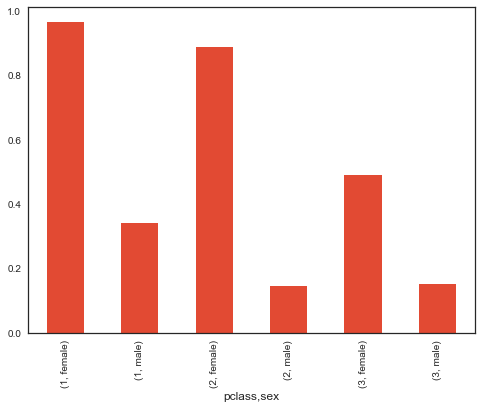

In [6]:
class_sex_grouping['survived'].plot.bar()

While the Titanic was sinking, the officers famously prioritized who was allowed in a lifeboat with the strict maritime tradition of evacuating women and children first. Our statistical results clearly reflect the first part of this policy as, across all classes, women were much more likely to survive than the men. We can also see that the women were younger than the men on average, were more likely to be traveling with family, and paid slightly more for their tickets.

The effectiveness of the second part of this “Women and children first” policy can be deduced by breaking down the survival rate by age.

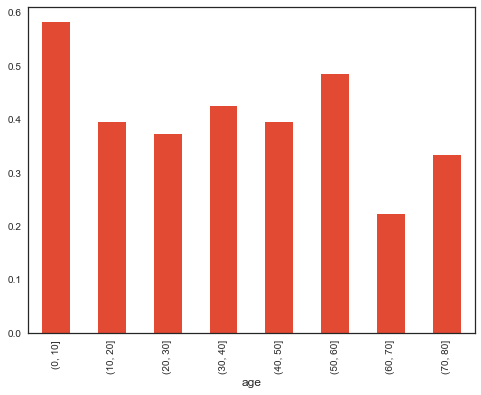

In [7]:
group_by_age = pd.cut(titanic["age"], np.arange(0, 90, 10))
age_grouping = titanic.groupby(group_by_age).mean()
age_grouping['survived'].plot.bar()

Here we can see that children were indeed the most likely age group to survive, although this percentage was still tragically below 60%.

In [9]:
titanic_numerical = titanic._get_numeric_data()

In [10]:
titanic_categorical = titanic.drop(titanic_numerical.columns, axis=1)

In [11]:
titanic_numerical.head()

,pclass,survived,age,sibsp,parch,fare,body
0,1,1,29.0000,0,0,211.3375,NaN
1,1,1,0.9167,1,2,151.5500,NaN
2,1,0,2.0000,1,2,151.5500,NaN
3,1,0,30.0000,1,2,151.5500,135.0
4,1,0,25.0000,1,2,151.5500,NaN


In [13]:
titanic_categorical.head()

,name,sex,ticket,cabin,embarked,boat,home.dest
0,"Allen, Miss. Elisabeth Walton",female,24160,B5,S,2,"St Louis, MO"
1,"Allison, Master. Hudson Trevor",male,113781,C22 C26,S,11,"Montreal, PQ / Chesterville, ON"
2,"Allison, Miss. Helen Loraine",female,113781,C22 C26,S,NaN,"Montreal, PQ / Chesterville, ON"
3,"Allison, Mr. Hudson Joshua Creighton",male,113781,C22 C26,S,NaN,"Montreal, PQ / Chesterville, ON"
4,"Allison, Mrs. Hudson J C (Bessie Waldo Daniels)",female,113781,C22 C26,S,NaN,"Montreal, PQ / Chesterville, ON"


### Numerial Imputation

In [14]:
from sklearn.preprocessing import Imputer

In [15]:
imput_numerical = Imputer(missing_values='NaN', strategy='median')

In [17]:
imput_numerical.fit(titanic_numerical) # recording median for each column

Imputer(axis=0, copy=True, missing_values='NaN', strategy='median', verbose=0)

In [18]:
titanic_numerical.isnull().sum()

pclass         0
survived       0
age          263
sibsp          0
parch          0
fare           1
body        1188
dtype: int64

In [19]:
imput_numerical.transform(titanic_numerical)

array([[   1.    ,    1.    ,   29.    , ...,    0.    ,  211.3375,  155.    ],
       [   1.    ,    1.    ,    0.9167, ...,    2.    ,  151.55  ,  155.    ],
       [   1.    ,    0.    ,    2.    , ...,    2.    ,  151.55  ,  155.    ],
       ..., 
       [   3.    ,    0.    ,   26.5   , ...,    0.    ,    7.225 ,  304.    ],
       [   3.    ,    0.    ,   27.    , ...,    0.    ,    7.225 ,  155.    ],
       [   3.    ,    0.    ,   29.    , ...,    0.    ,    7.875 ,  155.    ]])

In [20]:
numerical_data_imputed = pd.DataFrame(imput_numerical.transform(titanic_numerical))

In [21]:
numerical_data_imputed.head()

,0,1,2,3,4,5,6
0,1.0,1.0,29.0000,0.0,0.0,211.3375,155.0
1,1.0,1.0,0.9167,1.0,2.0,151.5500,155.0
2,1.0,0.0,2.0000,1.0,2.0,151.5500,155.0
3,1.0,0.0,30.0000,1.0,2.0,151.5500,135.0
4,1.0,0.0,25.0000,1.0,2.0,151.5500,155.0


In [22]:
numerical_data_imputed.columns = titanic_numerical.columns
numerical_data_imputed.index = titanic_numerical.index

In [23]:
numerical_data_imputed.head()

,pclass,survived,age,sibsp,parch,fare,body
0,1.0,1.0,29.0000,0.0,0.0,211.3375,155.0
1,1.0,1.0,0.9167,1.0,2.0,151.5500,155.0
2,1.0,0.0,2.0000,1.0,2.0,151.5500,155.0
3,1.0,0.0,30.0000,1.0,2.0,151.5500,135.0
4,1.0,0.0,25.0000,1.0,2.0,151.5500,155.0


In [24]:
numerical_data_imputed.isnull().sum()

pclass      0
survived    0
age         0
sibsp       0
parch       0
fare        0
body        0
dtype: int64

### Categorical Imputation

In [25]:
titanic_categorical.isnull().sum()

name            0
sex             0
ticket          0
cabin        1014
embarked        2
boat          823
home.dest     564
dtype: int64

In [26]:
categorical_imputed = titanic_categorical.fillna(value="KOSONG")

In [27]:
categorical_imputed.isnull().sum()

name         0
sex          0
ticket       0
cabin        0
embarked     0
boat         0
home.dest    0
dtype: int64

In [29]:
titanic.head(2)

,pclass,survived,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked,boat,body,home.dest
0,1,1,"Allen, Miss. Elisabeth Walton",female,29.0000,0,0,24160,211.3375,B5,S,2,NaN,"St Louis, MO"
1,1,1,"Allison, Master. Hudson Trevor",male,0.9167,1,2,113781,151.5500,C22 C26,S,11,NaN,"Montreal, PQ / Chesterville, ON"


In [36]:
title = pd.DataFrame()
# we extract the title from each name
title[ 'Title' ] = titanic[ 'name' ].map( lambda name: name.split( ',' )[1].split( '.' )[0].strip() )

title.head()

,Title
0,Miss
1,Master
2,Miss
3,Mr
4,Mrs


In [45]:
cabin = pd.DataFrame()
cabin['Cabin'] = categorical_imputed['cabin'].map( lambda cabin: cabin[0].strip() )

In [63]:
cabin.head()

,Cabin
0,B
1,C
2,C
3,C
4,C


In [87]:
home = pd.DataFrame()
home['home'] = categorical_imputed[ 'home.dest' ]
# we extract the title from each name
home[ 'home' ] = home[ 'home' ].map( lambda home: home.split(',')[0] )

home.head()

,home
0,St Louis
1,Montreal
2,Montreal
3,Montreal
4,Montreal


In [89]:
categorical_imputed.head()

,name,sex,ticket,cabin,embarked,boat,home.dest
0,"Allen, Miss. Elisabeth Walton",female,24160,B5,S,2,"St Louis, MO"
1,"Allison, Master. Hudson Trevor",male,113781,C22 C26,S,11,"Montreal, PQ / Chesterville, ON"
2,"Allison, Miss. Helen Loraine",female,113781,C22 C26,S,KOSONG,"Montreal, PQ / Chesterville, ON"
3,"Allison, Mr. Hudson Joshua Creighton",male,113781,C22 C26,S,KOSONG,"Montreal, PQ / Chesterville, ON"
4,"Allison, Mrs. Hudson J C (Bessie Waldo Daniels)",female,113781,C22 C26,S,KOSONG,"Montreal, PQ / Chesterville, ON"


In [98]:
categorical_imputed_reduction = categorical_imputed[['sex','ticket','embarked']]

In [99]:
categorical_concat = pd.concat([categorical_imputed_reduction, title,cabin,home], axis =1)

In [102]:
categorical_concat.isnull().sum()

sex         0
ticket      0
embarked    0
Title       0
Cabin       0
home        0
dtype: int64

In [103]:
categorical_dummy = pd.get_dummies(categorical_concat)

In [104]:
categorical_dummy.head()

,sex_female,sex_male,ticket_695,ticket_5727,ticket_11751,ticket_11755,ticket_11767,ticket_11769,ticket_11770,ticket_11813,...,home_Weston-Super-Mare / Moose Jaw,home_Wiltshire,home_Wimbledon Park,home_Windsor,home_Winnipeg,home_Woodford County,home_Worcester,home_Yoevil,home_Youngstown,home_Zurich
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [106]:
print(numerical_data_imputed.shape, categorical_dummy.shape)

((1309, 7), (1309, 1304))


In [107]:
titanic_concat = pd.concat([numerical_data_imputed, categorical_dummy], axis =1)

In [108]:
titanic_concat.head()

,pclass,survived,age,sibsp,parch,fare,body,sex_female,sex_male,ticket_695,...,home_Weston-Super-Mare / Moose Jaw,home_Wiltshire,home_Wimbledon Park,home_Windsor,home_Winnipeg,home_Woodford County,home_Worcester,home_Yoevil,home_Youngstown,home_Zurich
0,1.0,1.0,29.0000,0.0,0.0,211.3375,155.0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1.0,1.0,0.9167,1.0,2.0,151.5500,155.0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
2,1.0,0.0,2.0000,1.0,2.0,151.5500,155.0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1.0,0.0,30.0000,1.0,2.0,151.5500,135.0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
4,1.0,0.0,25.0000,1.0,2.0,151.5500,155.0,1,0,0,...,0,0,0,0,0,0,0,0,0,0


In [109]:
X = titanic_concat.drop(['survived'], axis=1).values
y = titanic_concat['survived'].values

In [111]:
from sklearn import datasets, svm, cross_validation, tree, preprocessing, metrics

In [144]:
X_train, X_test, y_train, y_test = cross_validation.train_test_split(X,y,test_size=0.2,random_state = 123)

In [146]:
## collect all model in one list
all_model = [DecisionTreeClassifier,
            LogisticRegression,
            KNeighborsClassifier,
            GaussianNB,
            SVC,
            LinearSVC,
            RandomForestClassifier,
            GradientBoostingClassifier,
            KNeighborsClassifier]
all_model

[sklearn.tree.tree.DecisionTreeClassifier,
 sklearn.linear_model.logistic.LogisticRegression,
 sklearn.neighbors.classification.KNeighborsClassifier,
 sklearn.naive_bayes.GaussianNB,
 sklearn.svm.classes.SVC,
 sklearn.svm.classes.LinearSVC,
 sklearn.ensemble.forest.RandomForestClassifier,
 sklearn.ensemble.gradient_boosting.GradientBoostingClassifier,
 sklearn.neighbors.classification.KNeighborsClassifier]

In [150]:
## loop for all model

datatr = []
datasc = []
for i in all_model:
    model = i()
    model.fit(X_train,y_train)
    datatr.append(model.score( X_train , y_train ))
    datasc.append(model.score( X_test , y_test ))
    print(i, model.score( X_train , y_train ) , model.score( X_test , y_test ))

(<class 'sklearn.tree.tree.DecisionTreeClassifier'>, 1.0, 0.82442748091603058)
(<class 'sklearn.linear_model.logistic.LogisticRegression'>, 0.9063992359121299, 0.83206106870229013)
(<class 'sklearn.neighbors.classification.KNeighborsClassifier'>, 0.81566380133715377, 0.72519083969465647)
(<class 'sklearn.naive_bayes.GaussianNB'>, 0.95128939828080228, 0.58396946564885499)
(<class 'sklearn.svm.classes.SVC'>, 0.72110792741165231, 0.7137404580152672)
(<class 'sklearn.svm.classes.LinearSVC'>, 0.63992359121298947, 0.62977099236641221)
(<class 'sklearn.ensemble.forest.RandomForestClassifier'>, 0.98376313276026739, 0.82442748091603058)
(<class 'sklearn.ensemble.gradient_boosting.GradientBoostingClassifier'>, 0.85768863419293218, 0.83587786259541985)
(<class 'sklearn.neighbors.classification.KNeighborsClassifier'>, 0.81566380133715377, 0.72519083969465647)


In [151]:
## compare model each other

data1 = pd.DataFrame()
data1['model'] = all_model
data1['score training'] = datatr
data1['score test'] = datasc
data1

,model,score training,score test
0,<class 'sklearn.tree.tree.DecisionTreeClassifi...,1.000000,0.824427
1,<class 'sklearn.linear_model.logistic.Logistic...,0.906399,0.832061
2,<class 'sklearn.neighbors.classification.KNeig...,0.815664,0.725191
3,<class 'sklearn.naive_bayes.GaussianNB'>,0.951289,0.583969
4,<class 'sklearn.svm.classes.SVC'>,0.721108,0.713740
5,<class 'sklearn.svm.classes.LinearSVC'>,0.639924,0.629771
6,<class 'sklearn.ensemble.forest.RandomForestCl...,0.983763,0.824427
7,<class 'sklearn.ensemble.gradient_boosting.Gra...,0.857689,0.835878
8,<class 'sklearn.neighbors.classification.KNeig...,0.815664,0.725191


In [152]:
data1[data1['score test']==data1['score test'].max()]

,model,score training,score test
7,<class 'sklearn.ensemble.gradient_boosting.Gra...,0.857689,0.835878
